In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 09 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Michael Steinbach <stei0062@umn.edu>, Nico Adams adams900@umn.edu


with contributions totally ripped off from Gautham Narayan (UIUC)

# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis

# Last Class: Dimensionality Reduction / Principle Component Analysis

# This Class: Principle Component Analysis, Take 2

## The Setup:

#### Given some measurement of a source on the sky, we want to decide if they're a white dwarf/giant/main sequence stat/QSO/etc.

#### This lets us look at a population of objects and that is useful if we want to do things like infer population hyperparameters

#### We already have a way to do this with stars:

<img src="figures/HR_diagram.jpg" width="50%">

#### BUT WE DO NOT MEASURE EITHER ABSOLUTE MAGNITUDE/TEMPERATURE!

#### we don't know distance so we get apparent magnitudes, we can get colors, but lots of things affect colors of objects - e.g. dust

#### Dust makes things red - it makes it hard to distinguish between a star that is red intrinsically or because it is extincted

#### If broadband magnitudes don't really have sufficient information to determine spectral class (though one group is going to try for their final!) then the only thing we can do is get better measurements with more information

#### What we can measure that isn't impacted as much by dust is spectra 

#### Dust is a broad continuum effect and doesn't impact sharp spectral lines 

*Note: image of spectral features*

<img src="figures/stellar_spectra.jpg">

#### Spectra are how Willamina Fleming first came up with the first classification scheme (A = most hydrogen, B = slightly less hydrogen...)

#### (It wasn't until Annie Jump Cannon reordered this into a temperature scale that we got the current classification order) 

#### Spectra might give us a way of classifying objects, but we can't be doing this by eye anymore like Willamina Fleming

#### DESI has 5000 fibers so ~100,000 spectra/night


<img src="figures/DESI-focal-plane-5K-robots.jpg">

#### We have some labelled spectra so one option is to train a ML classifier like a random forest on those spectra with labels and use them to predict labels for other objects without labels

#### But the problem is that the training set may not be representative - DESI is a new instrument on a 4m telescope on a good site, but if we use historical spectra they're from a different site with a different instrument

#### Moreover, DESI is looking at objects at higher-redshifts and will at not just stars, but also galaxies and everything else there is - entire classes may not be in the training set

#### So that suggests that we don't try supervised learning approaches but rather group objects by how similar their spectra are - clustering

#### Because this is an unsuperivsed learning approach and we don't need labels, we can potentially identify groups that we've not studied well before (e.g. Changing look AGN)

## OK, so this is in principle a good idea but there is a challenge

- If we want to define a cluster, what we really mean is that we are taking some N-dimensional space and within in enclosing off some volume

- Points inside the volume are cluster members, and points outside are not

- Lets imagine for a second that we define that volume as a multi-variate Gaussian

- In 2D that looks like this ellipse:
<img width="500" src="figures/pca-scatter.png">

- To define a multivariate Gaussian you need the mean and the covariance
    - in 1-D this is 1 for the mean and 1 for the variance
    - in 2-D this is 2 for the mean (x, y) and 4 for the covariance matrix (2x2)
    - in N-D this is N for the mean + NxN for the covariance

We've seen this already with MCMC - this is the *curse of dimensionality* (which would make a really good band name coming to think of it)

In [1]:
# RUN THIS
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA 
from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

Our spectra have 1000 features/dimensions
We have 4000 spectra/samples


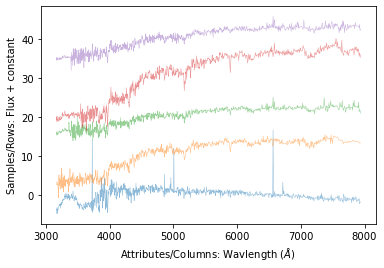

In [2]:
# AND RUN THIS
#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

for i in range(5):
    plt.plot(wavelengths, spectra[i] - spectra[i].mean() + 10*i, lw=0.5, alpha=0.5 )
plt.xlabel('Attributes/Columns: Wavlength ($\AA$)')
plt.ylabel('Samples/Rows: Flux + constant')
print(f'Our spectra have {len(wavelengths)} features/dimensions')
print(f'We have {len(spectra)} spectra/samples')

#### So a naive estimate is that to define just one cluster in spectrum space, we need ~1E6 parameters...

#### That's obviously not going to cut it

#### But just because a spectrum has a 1000 measurements of flux with wavelength, do we actually need a 1000 numbers to describe it?

#### With periodic time-series, even if we had N measurements as a function of time, we could express them as a sum of Fourier components 
    - This is dimensionality reduction - rather than store the original N measurements, we store amplitudes and phases for hopefully a few Fourier components
    - A clever choice of basis (sinusoids) makes this possible because the particular choice of basis vectors encode a lot of the variation in the data

## Can we play the same game with spectra - i.e. can we describe a 1000 element row vector with fewer numbers?

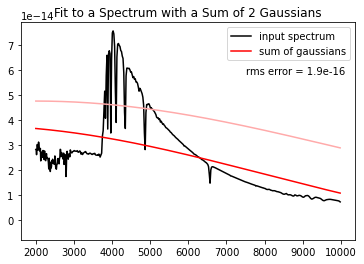

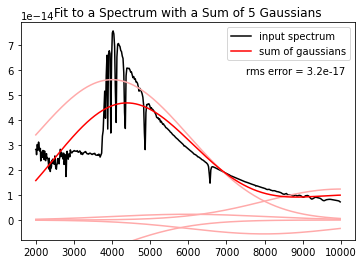

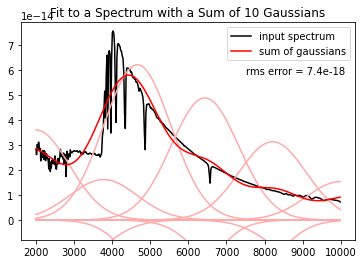

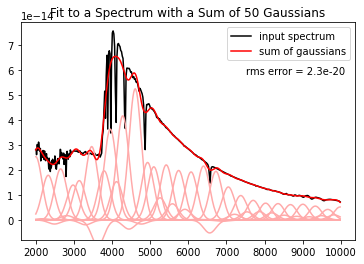

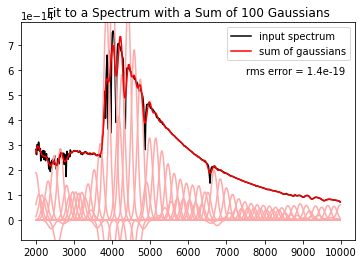

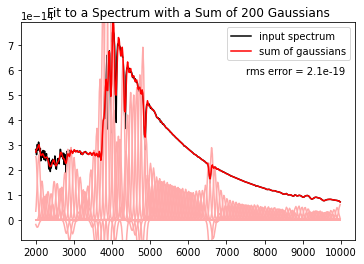

In [4]:
# RUN THIS
from matplotlib import pyplot as plt
from astroML.datasets import fetch_vega_spectrum
from astroML.sum_of_norms import sum_of_norms, norm

# Fetch the data
x, y = fetch_vega_spectrum()

# truncate the spectrum
mask = (x >= 2000) & (x < 10000)
x = x[mask]
y = y[mask]

for n_gaussians in (2,5,10, 50, 100, 200):
    # compute the best-fit linear combination
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)

    # plot the results
    plt.figure()
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    plt.plot(x, norms, ls='-', c='#FFAAAA')
    plt.plot(x, norms.sum(1), '-r', label='sum of gaussians')
    plt.ylim(-0.1 * ylim[1], ylim[1])

    plt.legend(loc=0)

    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()

*Note: so, we can create a model of our data with a much smaller set of parameters (here params of the Gaussians)*

<img src="figures/chernobyl.jpg" width="30%">

### Gaussians are not the best choice of basis vectors to describe the variation of spectra

### They work pretty well to describe spectral lines, but a Gaussian doesn't look like a whole spectrum...

### But what this is telling us is that the flux (at least at nearby wavelengths) is *correlated*

### We want to compare all the spectra on an equal footing, but they have vastly different fluxes, so we'll normalize first by subtracting the mean (i.e. centering on 0) and dividing by standard deviation - this way we are comparing **shapes** of the spectra

Text(0, 0.5, 'Flux at 3531.8 $\\AA$')

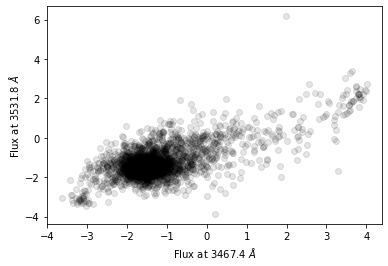

In [5]:
# RUN THIS
from scipy.stats import zscore
x = 100
y = 120
# This just subtracts the mean flux of each spectrum and divides by the standard deviation - i.e. renormalization
whiten = zscore(spectra, axis=1)
plt.scatter(whiten[:,x], whiten[:,y], color='k', marker='o', alpha=0.1)
plt.xlabel(f'Flux at {wavelengths[x]:.1f} $\AA$')
plt.ylabel(f'Flux at {wavelengths[y]:.1f} $\AA$')

# In-class warm-up: computing a correlation matrix


Actually these correlations are not just on short length scales in wavelength, but on quite long scales

That shouldn't be shocking - each spectra is ~a Blackbody (1 number) + some hydrogen and helium + a little bit of ~ average stuff that is not hydrogen and helium in the Universe. 

Instead of just looking at two wavelengths, we can look at all of them at once in a correlation matrix:

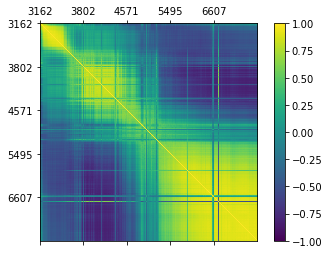

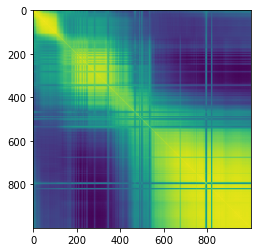

In [9]:
# RUN THIS
fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(np.corrcoef(whiten, rowvar=False), vmin=-1, vmax=1)
ax.set_xticks(np.arange(0, len(wavelengths)-1, 200))
ax.set_yticks(np.arange(0, len(wavelengths)-1, 200))
xticks = ax.get_xticks()
ticklabels = [f'{wavelengths[int(x)]:.0f}' for x in xticks]
ax.set_yticklabels(ticklabels)
ax.set_xticklabels(ticklabels)
plt.colorbar(cax)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
corr=np.corrcoef(whiten,rowvar=False)
ax.imshow(corr)

#### This structure makes sense

#### Since there is so much correlation (i.e. flux at different wavelengths are not independent of each other) we can reduce those 1000 numbers per spectra to a much smaller set if we can pick a good basis

# Principal Component Analysis is one way to contruct a set of basis functions from the data itself


#### The idea of principal components analysis (PCA) is to find a small number of linear combinations of the variables so as to capture most of the variation in the data as a whole.

#### Principal components analysis finds a set of orthogonal standardized **linear combinations** which together explain all of the variation in the original data. 

#### There are as many principal components as there are features/attributes, but the way PCA is constructed the components are ordered such that the first explains most of the variance in the data, the second explains a bit less and so on

#### So we can truncate the total number of components, trading off some accuracy for reducing dimensionality/complexity of the data

#### Because this is a linear transformation we can write this as 


$$T s_{1}=v_{1}$$
$$T s_{2}=v_{2}$$
$$T s_{n}=v_{n}$$

or

$$T s_{i}=v_{i}$$

#### Under this transformation, there are some specific vectors that change length but do not change direction - i.e. basis vectors

$$T b_{i} = \lambda_{i} b_{i} $$

or in matrix form

$$ \mathbf{T}\cdot \mathbf{B} = \vec{L}\cdot\mathbf{B}$$

$\mathbf{B}$ is basis vectors, $\vec{L}$ is eigenvalues

We can sort the vectors/rows in $\mathbf{B}$ such that the largest eigenvalue is first

### To find the basis vectors $\mathbf{B}$ from the data $\mathbf{S}$:

- Subtract of the mean of each column and divide by standard deviation (optional but usually a good idea) = $\mathbf{Z}$
- Construct $\mathbf{Z}^T \cdot \mathbf{Z}$
- Decompose into $\mathbf{B} \cdot \mathbf{L} \cdot \mathbf{B}^{-1}$ where $\mathbf{L}$ is a diagonal matrix with the scalar eigenvalues on the diagonal 
- Take the eigenvalues and sort from highest to lowest and sort the columns of the $\mathbf{B}$ accordingly
- Figure out the projection of the data onto the new basis vectors

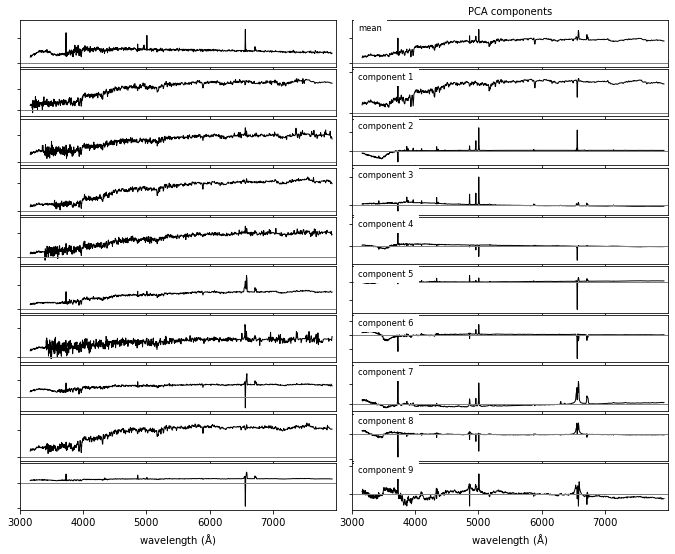

In [10]:
#----------------------------------------------------------------------
# Compute PCA
def compute_PCA(n_components=5):

    nrows = 500
    ind = np.random.randint(spectra.shape[0], size=nrows)
    
    # we're using only nrows to do the PCA and setting the mean as the first component
    spec_mean = spectra[ind].mean(0)
    pca = PCA(n_components - 1)
    
    pca.fit(spectra[ind])
    # the PCA eigen"spectra" are:
    pca_comp = np.vstack([spec_mean,
                          pca.components_])
    
    # and the explained variance is:
    evals = pca.explained_variance_ratio_

    return pca_comp, evals, pca


# YOU CAN CHANGE THIS 
n_components = 10
decompositions, evals, pca = compute_PCA(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'

for j in range(n_components):
    ax = fig.add_subplot(n_components, 2, 2*j+2)

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax.plot(wavelengths, decompositions[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()

#### Comparisons between the eigenvectors derived from PCA and known spectral types of galaxies have shown that the eigenspectra correlate strongly with specific physical properties 

#### Now that you have your new basis vectors that are orthogonal, just as you calculated the variance of the data along say the $x$ axis, you can compute it along the $PC_1$ axis. 

#### The total variance is the sum of variances of all individual principal components.

#### The fraction of variance explained by a principal component is the ratio between the variance of that principal component and the total variance.

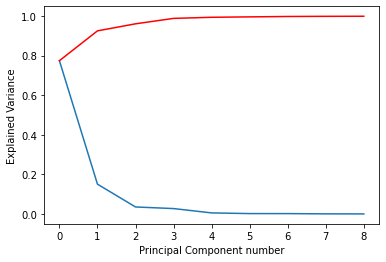

In [11]:
plt.plot(evals, label='Variance explained by this component')
plt.plot(np.cumsum(evals), 'r-', label='Total Explained variance')
plt.xlabel('Principal Component number')
plt.ylabel('Explained Variance')
ax = plt.gca()
ax.set_xticks(range(n_components-1));

*Note:similar to a Pareto plot*

### This is useful because a small number of components is enough to represent the original data - DIMENSIONALITY REDUCTION

In [13]:
pca_transformed = pca.transform(spectra)
print('Original data:', spectra.shape)
print('PCA transformed data:',pca_transformed.shape)

Original data: (4000, 1000)
PCA transformed data: (4000, 9)


### Remember that PCA is a linear method

Text(0, 0.5, 'Component 3')

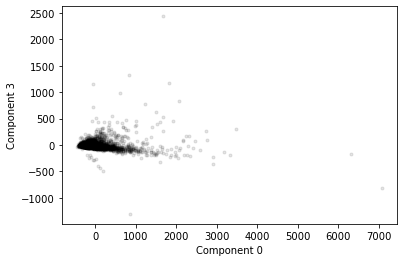

In [14]:
plt.scatter(pca_transformed[:,0], pca_transformed[:,2], marker='.', color='k', alpha=0.1)
plt.xlabel('Component 0')
plt.ylabel('Component 3')

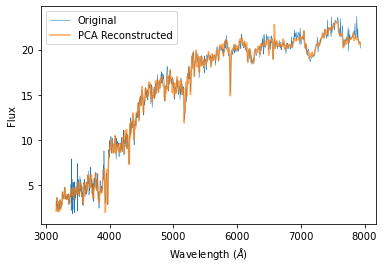

In [15]:

index = 50
plt.plot(wavelengths, spectra[index],  lw=0.5, label='Original')
plt.plot(wavelengths, pca.inverse_transform(pca_transformed[index]), label='PCA Reconstructed', alpha=0.7)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend()

## WARNINGS: 

#### Given the cumulative nature of the sum of variances used in PCA, astrophysically interesting components within the spectra (e.g., sharp spectral lines or transient features for certain galaxy populations) may not be reflected in the largest PCA components. 

#### the assumption that a sum of linear components can efficiently reconstruct the features within the data does not always hold. 

#### An example of this is the variation in broad emission lines (such as those from quasars). The variation in line width is an inherently nonlinear process and can require a large number of components to fully characterize

#### For broad line quasars over 30 components are required to reproduce the underlying spectra compared to the ~10 required for quiescent and star-forming galaxies. 

#### There are non-linear dimensionality reduction methods (Locally Linear Embedding, IsoMaps) that will do better

#### How do you know if you need linear vs non-linear methods: LOOK AT YOUR DATA

Text(0, 0.5, 'Component 3')

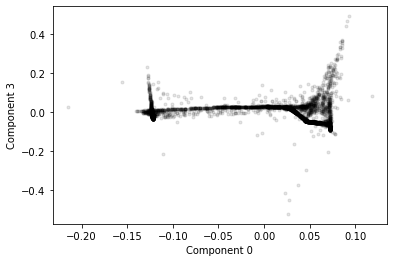

In [16]:
from sklearn.manifold import LocallyLinearEmbedding
np.random.seed(42)
nrows = 200
ind = np.random.randint(spectra.shape[0], size=nrows)
embedding = LocallyLinearEmbedding(n_components=n_components)
embedding.fit(spectra[ind])
lle_transformed = embedding.transform(spectra)
plt.scatter(lle_transformed[:,0], lle_transformed[:,3], marker='.', color='k', alpha=0.1)
plt.xlabel('Component 0')
plt.ylabel('Component 3')

### But because LLE is non-linear there is no unique way to reconstruct the data

i.e. dimensionality reduction doesn't mean there is an inverse transformation - this is why PCA is still really useful compared to say t-SNE/LLE/Isomaps.

## OK so we've gone from 1000 dimensions to a few so now we if we want to define a cluster in N-dimensional space (which again needs ~ N^2 parameters, we've got a much easier job)


#### So how do we find clusters or estimate density efficiently?

The most basic approach to finding clusters that is $K$-means (simple, works well)

$K$-means partitions points into $K$ disjoint subsets ($C_k$) with each subset containing $N_k$ points

It minimizes the objective/cost/likelihood function, 

#### $$\sum_{k=1}^K \sum_{i \in C_k} || x_i - \mu_k ||^2$$

where $\mu_k = \frac{1}{N_k} \sum_{i \in C_k} x_i$ is the mean of the points in set (hence, $k$ means)

# In-class warm-up: k-Means


### Procedure/psuedo-code for k-Means:

1. define the number of clusters $K$
2. choose the centroid, $\mu_k$, of each of the $K$ clusters
3. assign each point to the cluster that it is closest to
4. update the centroid of each cluster by recomputing $\mu_k$ according to the new assignments.
5. goto (3) until there are no new assignments.

Global optima are not guaranteed but the process never increases the sum-of-squares error.

Like any algorithm with an element of stochasticity (here the initial guesses), it's a good idea to run multiple times with different starting values for the centroids of $C_k$.

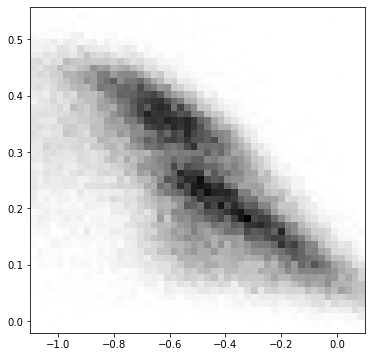

In [17]:
# RUN THIS

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T
X = X.astype(np.float)

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

# Visualize the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

In [26]:
## RUN THIS

#------------------------------------------------------------
# Compute the KMeans clustering


### CHANGE ME
n_clusters = 10

scaler = preprocessing.StandardScaler()
scaler.fit(X)
scaler.transform(X)
clf = KMeans(n_clusters=n_clusters)
clf.fit(scaler.transform(X))

KMeans(n_clusters=10)

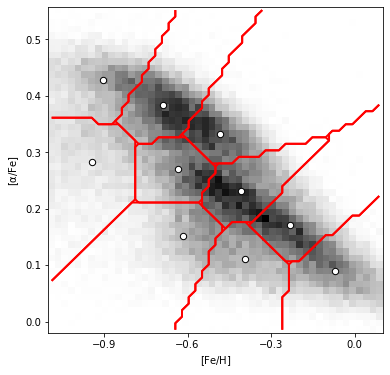

In [27]:
## RUN THIS

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# plot density again
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

Xtrain = scaler.transform(Xgrid).astype(np.float)
H_new = clf.predict(Xtrain).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H_new.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=2, colors='r')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show(fig)

### k-Means is a special case of a Mixture Model

Mixture models use the sum of functions to represent the density distributions - used in defining the density, classifications, cloning of a data set....

Gaussian mixture models (GMMs) are the most common implementation of mixture models where the model consists of $M$ multivariate Gaussians with locations $\mu_j$ and covariances $\Sigma_j$.

$k$-means is a special case of GMM, where we make a hard assignment of a point to a cluster rather than evaluate the probability that a point belongs to a cluster

## The log-likelihood is straightforward to define with Gaussians

### We have a density field with $N$ points:

$$\rho(\mathbf{x}) = N\, p(\mathbf{x}) = N\, \sum_{j=1}^M \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$$


### that is some linear combination of Gaussians with:

$$p(\mathbf{x}) = \sum_j \alpha_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_{j},\mathbf{\Sigma}_{j})$$

### and as usual each Gaussian is:

$$\mathcal{N}(\mathbf{x}|\mathbf{\mu}_j,\mathbf{\Sigma}_j) = \frac{1}{\sqrt{(2\pi)^D\mbox{det}(\mathbf{\Sigma}_j)}} \exp\Big(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}_j^{-1}(\mathbf{x}-\mathbf{\mu})\Big)\, $$

## The challenge here is that there's way more variables than the number of points so we have a coupled set of equations 

#### Not just means and variances but the class memberships - probability that a point belongs to each cluster - these are latent variables associated with every point

#### In the hierarchical Bayesian mold we could introduce hyperpriors to help. We're effectively doing the same thing here - fix population parameters (the means and variances) - compute class membership, then fix class membership and update population parameters

## This is called the Expectation Maximization (EM) algorithm

#### Expectation
    - Given a set of Gaussians compute the “expected” classes of all points

#### Maximization
    - Estimate the MLE of $\mu$, amplitude, and $\Sigma$ given the data’s class membership

As before iterate proceedure until variance does not change. 

#### Guaranteed to converge - but not to the correct answer (there isn't such a thing).

# In-class exercise: Gaussian Mixture Models

In [28]:
from sklearn import mixture
from scipy.stats import multivariate_normal

#Generate data
def gendata():
    obs = np.concatenate((1.6*np.random.randn(300, 2), 6 + 1.3*np.random.randn(300, 2), np.array([-5, 5]) + 1.3*np.random.randn(200, 2), np.array([2, 7]) + 1.1*np.random.randn(200, 2)))
    return obs

In [29]:
#Generate GMM model and fit the data
def gengmm(nc=4, n_iter = 2):
    g = mixture.GaussianMixture(n_components=nc, max_iter=n_iter, init_params='kmeans')  # number of components
    return g


def plotGMM(g, n, plot_contours=1):
    
    delta = 0.025
    x = np.arange(-10, 10, delta)
    y = np.arange(-6, 12, delta)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
 
    for i in range(n):
        plt.plot(g.means_[i][0],g.means_[i][1], '+', markersize=13, mew=3) 
        if plot_contours == 1:
            dist = multivariate_normal(g.means_[i,:], g.covariances_[i,:])
            Z1 = dist.pdf(pos)
            plt.contour(X, Y, Z1, linewidths=0.5)


In [30]:
obs = gendata()

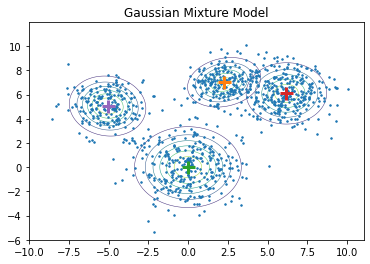

In [31]:
fig = plt.figure(1)

# CHANGE ME
ngauss = 4

g = gengmm(ngauss, 10)
g.fit(obs)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plotGMM(g, ngauss, 1)
plt.title('Gaussian Mixture Model')
plt.show()

/home/andrea/anaconda3/envs/astro/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


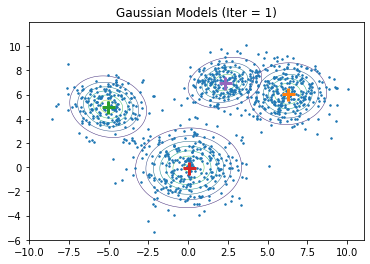

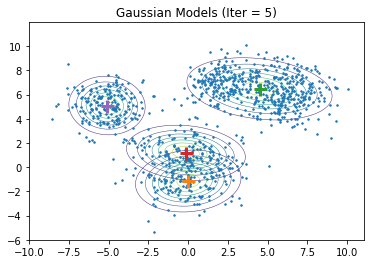

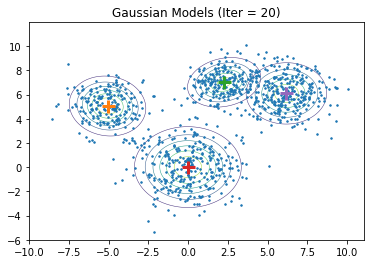

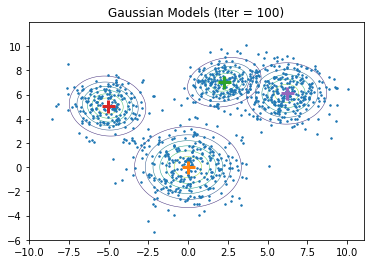

In [32]:
# note because of the stochasticity from the initial choices of positions from k-means
# you'll get different result when you rerun but there's also a chance that all the iterations look the same

g = gengmm(ngauss, 1)
g.fit(obs)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plotGMM(g, ngauss, 1)
plt.title('Gaussian Models (Iter = 1)')
plt.show()
 
g = gengmm(ngauss, 5)
g.fit(obs)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plotGMM(g, ngauss, 1)
plt.title('Gaussian Models (Iter = 5)')
plt.show()
 
g = gengmm(ngauss, 20)
g.fit(obs)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plotGMM(g, 4, 1)
plt.title('Gaussian Models (Iter = 20)')
plt.show()
 
g = gengmm(ngauss, 100)
g.fit(obs)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plotGMM(g, ngauss, 1)
plt.title('Gaussian Models (Iter = 100)')
plt.show()